# Rock Wall Hold GAN Train Script

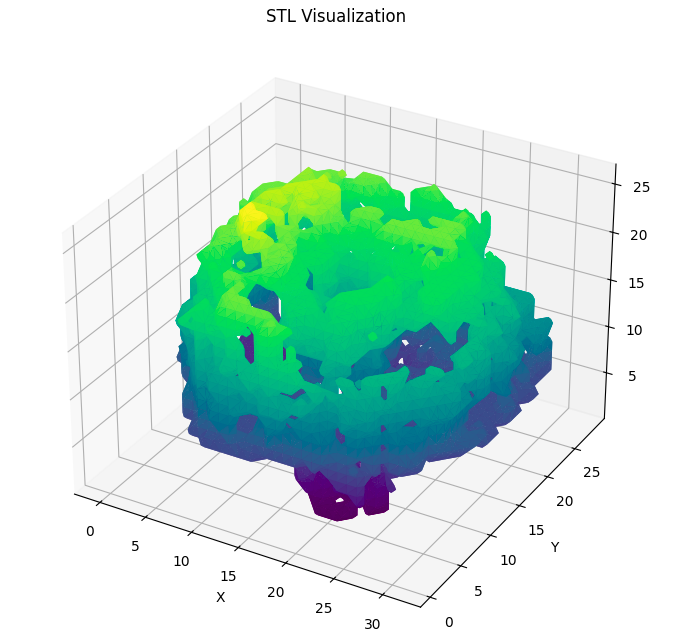

## Project Overview

This script trains a Generative Adversarial Network (GAN) to generate rock wall hold voxels. We then turn these voxels into meshes and save those meshes as STL files to 3D print the holds.

The real data used to train the GAN are open-source STL files of rock wall holds from Thingiverse. The entire data set comes from this [user](https://www.thingiverse.com/sardou3d/designs). We used the following packs from them:


*   [5x5 Holds Sample Pack](https://www.thingiverse.com/thing:6570167)
*   [10x5 Holds Sample Pack](https://www.thingiverse.com/thing:6571318)
*   [15x5 Holds Sample Pack](https://www.thingiverse.com/thing:6571323)
*   [Rock Sample Pack](https://www.thingiverse.com/thing:6572784)
*   [Jugs Sample Pack](https://www.thingiverse.com/thing:6580253)
*   [Finger Pocket Hold Pack](https://www.thingiverse.com/thing:6581243)
*   [Crack Crimp Pack Sample](https://www.thingiverse.com/thing:6605717)


## Notebook Table of Contents

1. Preparation and Setup
    1. Import libraries
    2. Set Device (CUDA or CPU)
    3. Mount Drive with Data
2. Training Preparation
    1. Define and Initialize the Custom Data Loader
    2. Define the Model Architectures
    3. Define the Custom Model Weights Initializer
    4. Define a Smoothness Loss Function
    5. Define Training Parameters
3. Model Training
    1. Training Loop
4. Model Performance Visualizations
    1. Visualize the Training Losses for Both Models
    2. Visualize Sample Generator Outputs

**Please note, this script assumes that you are either using our preprocessed dataset, or have preprocessed your own dataset of STLs without "data_preprocessing.py" script. Please make sure this is the case.**

## Preparation and Setup
This section makes sure we have everything we need to run the rest of the notebook. In order we:

1.   Import Libraries
2.   Set Device (CUDA or CPU)
3.   Mount Drive with Data



### Import libraries

In [2]:
# Google Colab Doesn't have trimesh installed by default. Run this cell if you
# are running this notebook in Colab
! pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.8/704.8 kB 41.6 MB/s eta 0:00:00


In [3]:
# "from google.colab import drive" is only necessary if running this notebook
# in Google Colab
from google.colab import drive
import os
import numpy as np
import random
import math
import argparse
import io
import pandas as pd
from IPython.display import HTML
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
import trimesh
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

### Set Device (CUDA or CPU)

In [4]:
# Defaults to CUDA if available, uses CPU if no CUDA GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Mount drive

This step is necessary if you are running in Google Colab. If you are using our data it will be at the file path:

1.   [/content/drive/My Drive/TanGen Data/processed_npys]() (The full dataset of 221 exemplars)

2.   [/content/drive/My Drive/TanGen Data/processed_npys_3]() (The reduced dataset of 48 exemplars)

You will need to add a shortcut to the data directories to your Drive to be able to load them in Colab.

You may also change the path in the data loader if you are using your own data or aren't using Google Colab.

Mounting the drive enables us to load our training data directory, which is stored [here.](https://drive.google.com/drive/folders/11Fx5bIrvJ41V4tOJ1ArG449eosoynq8_?usp=sharing) In this directory you will find both the full set of preprocessed data under "processed_npys", smaller preprocessed set under "processed_npys_3" and the unprocessed and sorted data under "TanGen - Holds".

In [5]:
drive.mount("/content/drive", force_remount=True);

Mounted at /content/drive


## Training Preparation

This section is meant to define all functions, helpers and parameters needed to train our model. In order we:

1. Define and Initialize the Custom Data Loader
2. Define the Model Architectures
3. Define the Custom Model Weights Initializer
4. Define a Smoothness Loss Function
5. Define Training Parameters

### Define and Initialize the Custom Data Loader

Define the Custom Data Loader

In [6]:
class VoxelizedHoldsDataset(Dataset):
    """
    Dataloader for the 32x32x32 binary occupancy numpy arrays.
    """

    def __init__(self, batch_size, data_dir_path):
        """
        Args:
            batch_size (int): The number of real data samples to be used in
                each training batch of our two models.
            data_dir_path (str): The path to the directory containing your
                pre-processed data. This should end in a "/" to allow for proper
                iteration through the dataset when getting data exemplars
        """
        self.batch_size = batch_size
        self.data_dir_path = data_dir_path

    def __len__(self):
        """
        Returns:
            self.batch_size (int): The number of real data samples to be used in
                each training batch of our two models.
        """
        return self.batch_size

    def __getitem__(self, idx):
        """
        Args:
            idx (int): The index value of the data sample you are extracting.
                from your dataset.

        Returns:
            Pytorch tensor for one "real" training data sample. Each will be of
            shape 1x1x32x32x32.
        """
        data_pt = np.load(f"{self.data_dir_path}{idx}.npy")
        dp = torch.tensor(data_pt, dtype=torch.float32)
        return dp.unsqueeze(0)

Initialize the Custom Data Loader

In [7]:
# Define the batch size and path to the data
batch_size=32
data_dir_path = "/content/drive/MyDrive/TanGen Data/processed_npys_3/"

dset = VoxelizedHoldsDataset(batch_size, data_dir_path)
dataloader = DataLoader(dset, batch_size=batch_size,
                        shuffle=True, num_workers=4)

### Define the Model Architectures

In [8]:
# Generator model
class Generator(nn.Module):
    """
    Class for a convolutional generator network to be used in a GAN for voxel
    data.
    """
    def __init__(self, in_channels=200, int_channels1=512, int_channels2=256, int_channels3=128, int_channels4=64):
        """
        Generator of a 3D convolutional GAN. Will produce 32x32x32 voxel arrays.
        It uses transpose convolutional layers to upsample data by a factor of 2
        after each layer. Starting at 1x1x1 voxels, upsampling through 5 layers.
        The first 4 layers are batch normalized and activated by Leaky Relu. The
        final layer is activated by a tanh function.

        The transpose convolutional layers have kernel size = 4, stride = 2, and
        input padding = 1, where padded by zeros.

        Args:
            in_channels (int): By default 200. The number of channels input into
                the model. Should be the dimensionality of the noise input
                vector.
            int_channels1 (int): By default 512. The number kernels in the first
                transpose convolutional layer of the generator.
            int_channels2 (int): By default 256. The number kernels in the
                second transpose convolutional layer of the generator.
            int_channels3 (int): By default 128. The number kernels in the third
                transpose convolutional layer of the generator.
            int_channels4 (int): By default 64. The number kernels in the fourth
                transpose convolutional layer of the generator.
        """
        super(Generator,self).__init__()

        # Define the model layers, all are transposed convolutional layers
        self.transpose_conv1 = nn.ConvTranspose3d(in_channels, int_channels1, kernel_size=4, stride=2, padding=1)
        self.transpose_conv2 = nn.ConvTranspose3d(int_channels1, int_channels2, kernel_size=4, stride=2, padding=1)
        self.transpose_conv3 = nn.ConvTranspose3d(int_channels2, int_channels3, kernel_size=4, stride=2, padding=1)
        self.transpose_conv4 = nn.ConvTranspose3d(int_channels3, int_channels4, kernel_size=4, stride=2, padding=1)
        self.transpose_conv5 = nn.ConvTranspose3d(int_channels4, 1, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm3d(int_channels1)
        self.bn2 = nn.BatchNorm3d(int_channels2)
        self.bn3 = nn.BatchNorm3d(int_channels3)
        self.bn4 = nn.BatchNorm3d(int_channels4)
        self.LeakyRelu = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x):
        """
        Forward pass through the generator model.

        Args:
            x (float32 PyTorch Tensor): An input data sample of noise for the
                generator to generate based off of.

        Returns:
            out (PyTorch Tensor): A generated 32x32x32 voxel tensor.
        """
        out = self.LeakyRelu(self.bn1(self.transpose_conv1(x)))
        out = self.LeakyRelu(self.bn2(self.transpose_conv2(out)))
        out = self.LeakyRelu(self.bn3(self.transpose_conv3(out)))
        out = self.LeakyRelu(self.bn4(self.transpose_conv4(out)))
        out = torch.tanh(self.transpose_conv5(out))

        # If all went well this should be a 1x32x32x32 tensor
        return out

# Discriminator model
class Discriminator(nn.Module):
    """
    Class for a convolutional discriminator network to be used in a GAN for
    voxel data.
    """
    def __init__(self, int_channels1=64, int_channels2=128, int_channels3=256, int_channels4=512):
        """
        Discriminator of a 3D convolutional GAN. Will produce a binary
        classification of "real" (1) or synthetic (0). It uses convolutional
        layers to downsample data by a factor of 2 after each layer. Starting at
        32x32x32 voxels, downsampling through 5 layers. There is no batch
        normalization. The first 4 layers are activated by Leaky ReLU. The final
        layer is activated by a sigmoid function. It takes a 32x32x32 binary
        voxel tensor as input.

        The convolutional layers have kernel size = 4, stride = 2, and input
        padding = 1, where padded by zeros.

        Args:
            int_channels1 (int): By default 64. The number kernels in the first
                convolutional layer of the discriminator.
            int_channels2 (int): By default 128. The number kernels in the
                second convolutional layer of the discriminator.
            int_channels3 (int): By default 256. The number kernels in the third
                convolutional layer of the discriminator.
            int_channels4 (int): By default 512. The number kernels in the
                fourth convolutional layer of the discriminator.
        """
        super(Discriminator,self).__init__()

        # Define the model layers, likely transposed convolutional layers
        self.conv1 = nn.Conv3d(1, int_channels1, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv3d(int_channels1, int_channels2, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv3d(int_channels2, int_channels3, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv3d(int_channels3, int_channels4, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv3d(int_channels4, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        """
        Forward pass through the discriminator model.

        Args:
            x (float32 PyTorch Tensor): An input data sample of either a real or
                synthetic 32x32x32 binary voxel tensor.

        Returns:
            out (PyTorch Tensor): Binary classification of "real" (1) or
                "synthetic" (0).
        """
        # Implement the forward pass of the model here
        out = F.leaky_relu(self.conv1(x))
        out = F.leaky_relu(self.conv2(out))
        out = F.leaky_relu(self.conv3(out))
        out = F.leaky_relu(self.conv4(out))
        out = F.sigmoid(self.conv5(out))

        # If all went well this should be a binary classification output
        return out

### Define the Custom Model Weights Initializer

In [9]:
def weights_init(m):
    """
    In the DCGAN paper, the authors specify that all model weights shall be
    randomly initialized from a Normal distribution with mean=0, stdev=0.02.

    This function takes an initialized model and reinitializes all
    convolutional, convolutional-transpose, and batch-norm layers so that they
    meet this criteria. This should be done to model right after intializing it.

    Args:
        m: The model who's weights you are reinitializing.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Define a Smoothness Loss Function

In [10]:
def smoothness_loss(fake):
    """
    Smoothness loss function for the generator model. It penalizes a lack of
    continuity.

    returns:
        smoothness_loss: A quantified value of how non-continuous the generated
            synthetic voxel tensor is.
    """
    return torch.sum(torch.abs(fake[:, :, :-1] - fake[:, :, 1:])) + \
           torch.sum(torch.abs(fake[:, :-1, :] - fake[:, 1:, :])) + \
           torch.sum(torch.abs(fake[:-1, :, :] - fake[1:, :, :]))

# A weighting factor for how harshly the generator model should be penalized for
# the discontinuities in its synthetic outputs.
lambda_smooth = 1e-5

### Defining Training Parameters

In [11]:
# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

# Batch size during training
batch_size = 32

# Number of training epochs
num_epochs = 600

# Learning rate for optimizers
lr_g = 0.0065
lr_d = 0.0002

Random Seed:  999


## Model Training

In this section we actually perform the training loop for the generator and discriminator models.

### Training Loop

**We started by using the train loop from this tutorial** https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html.

The train loop in this PyTorch tutorial was for generating 2D faces. We modified it to work with our model architecture and 3D rock wall hold data.  

In [12]:
"""
Training loop
"""

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

latent_noise_dimensions = 5

# Create the generator
netG = Generator(latent_noise_dimensions).to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Create the Discriminator
netD = Discriminator().to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, latent_noise_dimensions, 1, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 0.9
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(.2, 0.500))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(0.5, 0.999))

# Initialize progress bars for training

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)

        # # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # ## Train with all-fake batch
        # # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_noise_dimensions, 1, 1, 1, device=device)
        # # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # # Update D
        optimizerD.step()

        # ############################
        # # (2) Update G network: maximize log(D(G(z)))
        # ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # # Calculate G's loss based on this output
        errG = criterion(output, label) + lambda_smooth * smoothness_loss(fake)

        # # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # # Update G
        optimizerG.step()

        # # Output training stats
        epoch_display = epoch+1
        if epoch_display % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch_display, num_epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            save_path = "gan_checkpoint2.pth"

            # Save state dictionaries
            torch.save({
                'generator_state_dict': netG.state_dict(),
                'discriminator_state_dict': netD.state_dict(),
                'optimizer_g_state_dict': optimizerG.state_dict(),
                'optimizer_d_state_dict': optimizerD.state_dict(),
                'epoch': epoch  # Optional, useful for resuming training
            }, save_path);


        # # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1

Starting Training Loop...
[100/600][0/1]	Loss_D: 1.4641	Loss_G: 1.1243	D(x): 0.4618	D(G(z)): 0.5068 / 0.3260
[200/600][0/1]	Loss_D: 1.8400	Loss_G: 2.4731	D(x): 0.8024	D(G(z)): 0.7723 / 0.0692
[300/600][0/1]	Loss_D: 0.3493	Loss_G: 8.3429	D(x): 0.9530	D(G(z)): 0.0002 / 0.0001
[400/600][0/1]	Loss_D: 0.3350	Loss_G: 5.0949	D(x): 0.8692	D(G(z)): 0.0054 / 0.0037
[500/600][0/1]	Loss_D: 0.5612	Loss_G: 3.7446	D(x): 0.7991	D(G(z)): 0.1803 / 0.0163
[600/600][0/1]	Loss_D: 0.3280	Loss_G: 12.5081	D(x): 0.9215	D(G(z)): 0.0000 / 0.0000


## Model Performance Visualizations

In this section we review our models' performance after being trained. In order, we:

1. Visualize the Training Losses for Both Models
2. Visualize Sample Generator Outputs

### Visualize the Training Losses for Both Models

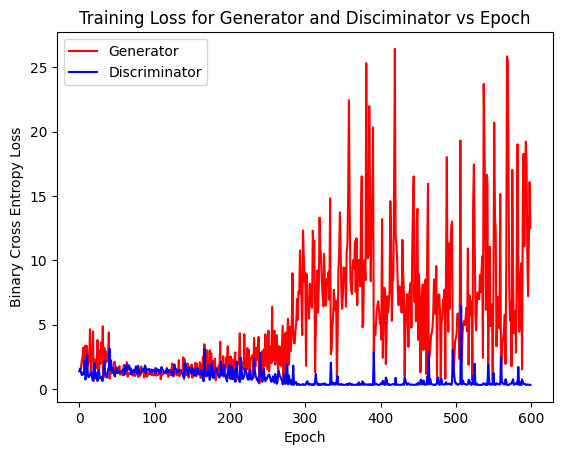

In [13]:
epochs_range_plotting = range(num_epochs)

plt.plot(epochs_range_plotting, G_losses, c='red')
plt.plot(epochs_range_plotting, D_losses, c='blue')

plt.title("Training Loss for Generator and Disciminator vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy Loss")
plt.legend(("Generator", "Discriminator"))

plt.show()

### Interactive Output Visualization

**Generating a Sample Output and Saving as STL**

In [16]:
noise = torch.randn(1, latent_noise_dimensions, 1, 1, 1, device=device)
fake = netG(noise).squeeze()
threshold = 0.65  # Adjust based on your use case
binary_fake = (fake > threshold).cpu().numpy().astype(bool)
print("Voxel grid unique values:", np.unique(binary_fake))
print(fake.shape)

new_voxel = trimesh.voxel.base.VoxelGrid(binary_fake)
print(f"voxel: {new_voxel.shape}")
mc = new_voxel.marching_cubes

# Save the remeshed surface as an STL file
mc.export("test5.stl");

Voxel grid unique values: [False  True]
torch.Size([32, 32, 32])
voxel: (32, 32, 32)


**Visualizing the Sample STL**

Sometimes we extract the largest connected component from the mesh when there is a lot of noise around the hold. That is what line 11 does. Sometimes, the hold is clean and we just export the entire mesh.

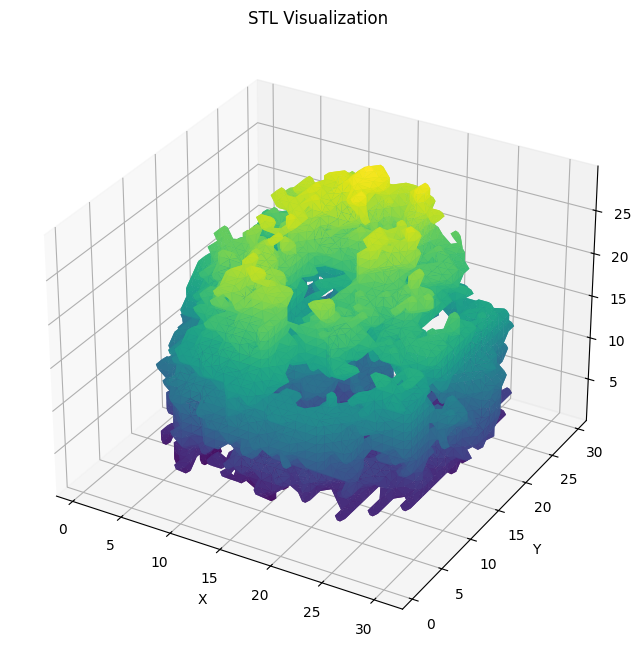

In [17]:
# Load the STL file
mesh = trimesh.load("test5.stl")

# Fill holes in the mesh
mesh.fill_holes()

# Split the mesh into components
components = mesh.split(only_watertight=False)

# Extract the largest component by volume
largest_component = max(components, key=lambda c: c.volume)

# Set mesh to largest component
mesh = largest_component

# Create a Matplotlib 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the mesh
ax.plot_trisurf(
    mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2],
    triangles=mesh.faces, cmap="viridis", edgecolor="none"
)

# Set labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("STL Visualization")

# Save the figure as an image
plt.savefig("stl_visualization.png")
plt.show()